# Directional Index Reversal and Momentum Strategy in Crypto

This is the notebook demonstrating the individual strategies and the combo portfolio performance. For in-depth explanation, please read the project README.md!

In [1]:
from binance.client import Client as bnb_client
import statsmodels.api as sm
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# # Get all USDT trading pairs - Uncomment to download and save to pickle

# client = bnb_client(tld='US')

# def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
#     data = client.get_historical_klines(symbol,freq,start_ts)
#     columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
#     'num_trades','taker_base_volume','taker_quote_volume','ignore']

#     data = pd.DataFrame(data,columns = columns)
    
#     # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
#     data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     return data 
# # Fetch all trading pairs
# exchange_info = client.get_exchange_info()

# # Extract all symbols that end with "USDT"
# univ = [symbol['symbol'] for symbol in exchange_info['symbols'] if symbol['quoteAsset'] == 'USDT']

# freq = '1h' #technically a period
# px = {}
# vol = {}
# high = {}
# low = {}
# for x in univ:
#     data = get_binance_px(x,freq)
#     px[x] = data.set_index('open_time')['close']
#     vol[x] = data.set_index('open_time')['volume']
#     high[x] = data.set_index('open_time')['high']
#     low[x] = data.set_index('open_time')['low']


# px = pd.DataFrame(px).astype(float)
# px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))

# vol = pd.DataFrame(vol).astype(float)
# vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

# high = pd.DataFrame(high).astype(float)
# high = high.reindex(pd.date_range(high.index[0],high.index[-1],freq=freq))

# low = pd.DataFrame(low).astype(float)
# low = low.reindex(pd.date_range(low.index[0],low.index[-1],freq=freq))

# ret = px.pct_change()

# Save to pickle to avoid long download
# px.to_pickle('full_usdt_df_'+ freq+'_px.pkl')
# ret.to_pickle('full_usdt_df_'+ freq+'_ret.pkl')
# vol.to_pickle('full_usdt_df_'+ freq+'_vol.pkl')
# high.to_pickle('full_usdt_df_'+ freq+'_high.pkl')
# low.to_pickle('full_usdt_df_'+ freq+'_low.pkl')

In [3]:
# Load data
px = pd.read_pickle('full_usdt_df_1d_px.pkl') #change file based on frequency
ret = pd.read_pickle('full_usdt_df_1d_ret.pkl') #change file based on frequency
vol = pd.read_pickle('full_usdt_df_1d_vol.pkl') #change file based on frequency
high = pd.read_pickle('full_usdt_df_1d_high.pkl') #change file based on frequency
low = pd.read_pickle('full_usdt_df_1d_low.pkl') #change file based on frequency

In [4]:
# Keep high price-volume coins for momentum calculation
price_vol = px.mean()*vol.mean()

threshold = 100_000
big_coins = price_vol[price_vol > threshold].index

ret_big = ret[big_coins]

## Functions

Define functions used in program

In [5]:
# Create a returns object

class returns:

    """Returns object:
       
       Given a portfolio of signals (port) and percent returns of a security (ret), this will output common metrics and variables used in
       performance evaluation and analysis.

       The purify() method performs a linear regression and extracts the residual from that regression. Pass in the appropriate beta for
       your regression.
       """
    
    def __init__(self, port, ret):
        self.port = port
        self.ret = ret

    # Normalize portfolio, usually done before gen_returns()
    def norm(self):
        self.port = self.port.divide(self.port.abs().sum(1),0)#.fillna(0) # normalize rows

    # Calculate returns and evaluation metrics
    def gen_returns(self, tcost_bps=20, N_trades = 365, print_results=False):
        self.gross_ret = (self.port.shift()*self.ret).sum(1)
        self.to = (self.port - self.port.shift()).abs().sum(1)
        self.mean_tcost = self.to.mean()*tcost_bps*1e-4
        self.net_ret = self.gross_ret.subtract(self.to*tcost_bps*1e-4,fill_value=0)
        self.mean_gross = self.gross_ret.mean()
        
        if print_results:
            print("Mean gross returns:", self.mean_gross,
             "\nMean tcosts:", self.mean_tcost,
             "\nMean net returns:", self.net_ret.mean(),
             "\nGross Sharpe:", self.gross_ret.mean()/self.gross_ret.std()*np.sqrt(N_trades), 
             "\nNet Sharpe:", self.net_ret.mean()/self.net_ret.std()*np.sqrt(N_trades),
             "\nMean turnover:", self.to.mean())

    # Purify strategy: Does linear regression on chosen beta and outputs alpha and information ratio
    def purify(self, beta, N_trades = 365, print_results=False):
        Y = self.net_ret.fillna(0)
        X = beta.fillna(0)
        X = sm.add_constant(X)
        
        results = sm.OLS(Y, X).fit()
        self.alpha = results.params['const'] + results.resid
        self.ir = self.alpha.mean()/self.alpha.std()*np.sqrt(N_trades)
        
        if print_results:
            print("params:",
            '\n',results.params,
            "\nt-values:", 
            '\n',results.tvalues,
            '\nInfo Ratio:', self.ir)



In [6]:
# Define average functions

# Simple moving average
def sma(asset_df, avg_time):
    return asset_df.rolling(window=avg_time).mean()

# Exponential (weighted) moving average
def ema(asset_df, alpha):
    return asset_df.ewm(alpha=alpha, adjust=False).mean()   


In [7]:
# Function to perform rolling regression

"""Can't use df.rolling(), only accepts scalar. Below is a multivariate multiple regression with a single coin as the 
independent variable and all other coins in the universe as dependent variables. Also finds correlation in rolling window
and only includes those coins."""

def rolling_regression(df, indep_var, window, corr_thresh=0.7):
    results = []
    consts = []
    
    # Manual rolling window regression
    for start in range(len(df) - window + 1):
        window_df = df.iloc[start:start + window]  
        X = window_df[indep_var].fillna(0)
        X = sm.add_constant(X)  
        Y = window_df.drop(columns=[indep_var]).fillna(0)
        corrs = window_df.corr().loc[indep_var].drop(indep_var)
        model = sm.OLS(Y, X).fit()
        beta_row = model.params.loc[indep_var].copy()   
        const_row = model.params.loc['const'].copy()     
        
        # For coins whose rolling correlation is below threshold, set regression outputs to 0
        for coin in beta_row.index:
            if abs(corrs.iloc[coin]) < corr_thresh:
                beta_row[coin] = 0   
                const_row[coin] = 0 
                
        results.append(beta_row)
        consts.append(const_row)
        
    betas = pd.DataFrame(results, index=df.index[window-1:])
    betas.columns = Y.columns
    consts = pd.DataFrame(consts, index=df.index[window-1:])
    consts.columns = Y.columns
    
    independent = df[indep_var].iloc[window:]
    dep_vars = df.drop(columns=[indep_var]).iloc[window:]
    
    return {'betas': betas, 'consts': consts, 'indep var':independent, 'dep vars':dep_vars}


In [8]:
# Pairs trade signal generation function

def pairs_trade(sec, basket, betas, threshold=1):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = basket - betas.multiply(sec,axis=0)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = diff.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal


# Pairs trade function but smooths residual with EMA
def pairs_trade_smooth(sec, basket, betas, threshold=1, alpha = 0.5):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = ema(basket - betas.multiply(sec,axis=0), alpha)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = diff.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal



In [9]:
# Directional index equations

def di_trend(high, low, close, alpha):

    # Positive directional movement
    pos_dm_condition = (high - high.shift(-1) > low.shift(-1) - low) & (high > high.shift(-1))
    pos_dm = (high - high.shift(-1)).where(pos_dm_condition, 0)

    # Negative directional movement
    neg_dm_condition = (high - high.shift(-1) < low.shift(-1) - low) & (low < low.shift(-1))
    neg_dm = (low.shift(-1) - low).where(neg_dm_condition, 0)

    # True Range
    hl = high - low
    hc = (high - close.shift(-1)).abs()
    cl = (close.shift(-1) - low).abs()   
    stacked = np.stack([hl.values, hc.values, cl.values], axis=0)
    tr = np.max(stacked, axis=0)
    tr = pd.DataFrame(tr, index=high.index, columns=high.columns)

    # Average directional index
    atr = ema(tr, alpha)
    pdi = ema(pos_dm, alpha)/atr
    ndi = ema(neg_dm, alpha)/atr

    di = (pdi-ndi).abs()/(pdi+ndi)
    di_sign = np.sign(pdi-ndi)

    return di, di_sign

In [10]:
# Make trend crossing functions

def trend_crossing(asset, fit, trend, threshold=0.3):
    
    diff = (asset - fit)/fit

    # Detect trend crossing with sign change and threshold on crossing strength and direction
    cross = diff.where(diff.shift()*diff < 0)
    cross = cross.where(trend.abs() >= threshold) 
    cross = cross.mask(cross > 0, 1).mask(cross < 0, -1)
    cross.ffill(inplace=True)  # Forward fill to maintain previous value
    
    return cross.fillna(0)


In [11]:
# Optimal portfolio weights given covariance and mean, regularize
def weights(sigma, mu, eps=1e-6):

    # Weighting by sharpe/information ratio, regularized
    sigma_reg = sigma + eps * np.eye(sigma.shape[0]) #Set eps to 0 to turn off regluarization
    wgt = mu / np.diag(sigma_reg) 
    wgt = (wgt+1)/2 #shift to [0,1]
    wgt = wgt / np.abs(wgt).sum()


    return wgt

In [12]:
# Drawdown
def drawdown(ret):
    dd = ret / ret.expanding(min_periods=1).max() - 1
    dd = dd.replace(-np.inf, np.nan)
    return dd

# Duration
def duration(ret):
    
    peak = ret.expanding(min_periods=1).max()
    res = pd.Series(index=ret.index)
    
    for dt in ret.index:
        
        if ret.loc[dt] >= peak.loc[dt]:
             res.loc[dt] = 0

        else:    
            res.loc[dt] = res.loc[:dt].iloc[-2] + 1

    return res


## Make cross-sectional training sets

In [25]:
# Make training set

# Use high market cap coins for target security, but trade on all coins.
rev_train = ret.copy()
rev_train_cols = rev_train.columns
high_rev_train = high[rev_train_cols]
low_rev_train = low[rev_train_cols]
close_rev_train = px[rev_train_cols]
master_sec_train = ret_big.columns[np.random.randint(0,ret_big.shape[1])] #Choose random big cap


# Select random columns from high market cap coins
mom_train = ret_big.fillna(0).sample(n=ret_big.shape[1]//2, axis=1, random_state=42)
mom_train_cols = mom_train.columns
high_mom_train= high[mom_train_cols].fillna(0)
low_mom_train = low[mom_train_cols].fillna(0)
close_mom_train = px[mom_train_cols].fillna(0)

## DI Reversal and Momentum Strategy

Mean gross returns: 0.0009459670198160731 
Mean tcosts: 0.00012563301009143723 
Mean net returns: 0.000822223717863978 
Gross Sharpe: 2.142723321090478 
Net Sharpe: 1.8820854229848043 
Mean turnover: 0.0628165050457186
params: 
 const      0.000834
DOTUSDT    0.019633
dtype: float64 
t-values: 
 const      4.399766
DOTUSDT    3.587040
dtype: float64 
Info Ratio: 1.9151337447745294


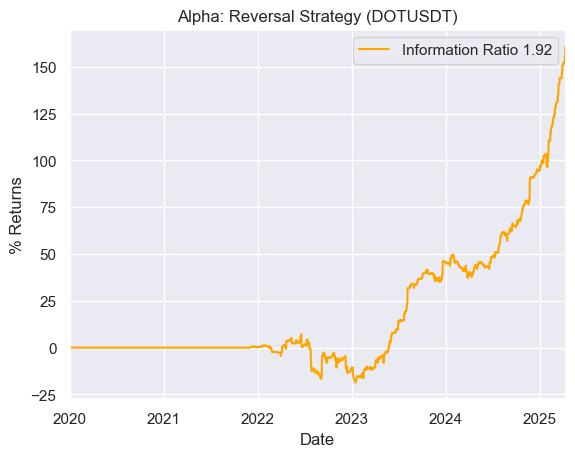

In [27]:
# Implement strategies

#### Reversal ####

# Perform rolling regression
window = 30
roll_reg = rolling_regression(rev_train, master_sec_train, window)

# Make trend signal
alpha = 0.35 #often 1/(day average), can be optimized
di = di_trend(high_rev_train,low_rev_train,close_rev_train,alpha)

# M/R sig threshold
thresh = 0.25
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

# Reversal components
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Reversal signal
rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5, alpha=0.2)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec_train] = -1*rev_port.sum(1)

rets = returns(rev_port, rev_train)
rets.norm()
rets.gen_returns(print_results = True)

beta = ret[master_sec_train].fillna(0)
rets.purify(beta, print_results = True)

(rets.alpha*100).cumsum().plot(title= f'Alpha: Reversal Strategy ({master_sec_train})', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}", color = 'orange')
plt.legend()


Mean gross returns: 0.0021567502733709216 
Mean tcosts: 0.00015000110966422966 
Mean net returns: 0.002006749163706692 
Gross Sharpe: 1.6059768162375652 
Net Sharpe: 1.4936655470813491 
Mean turnover: 0.07500055483211483
params: 
 const    0.001987
0        0.000918
dtype: float64 
t-values: 
 const    3.397784
0        0.999860
dtype: float64 
Info Ratio: 1.4795893068246575


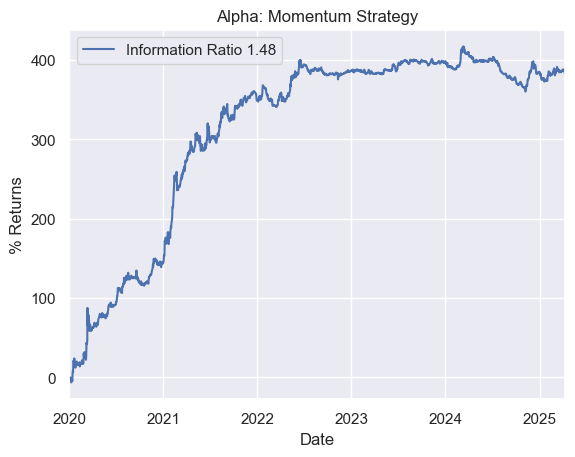

In [28]:
#### Momentum ####

# Momentum fits
asset = sma(mom_train, 5).cumsum()
fit = ema(mom_train, 0.1).cumsum()

# Make trend signal
alpha = 0.35 #often 1/(day average), can be optimized
di = di_trend(high_mom_train, low_mom_train, close_mom_train, alpha)


# M/R sig threshold
thresh = 0.25

# Momentum signal
mom_port = trend_crossing(asset, fit, di[0], threshold=thresh)

rets = returns(mom_port, mom_train)
rets.norm()
rets.gen_returns(print_results = True)

beta = mom_train.sum(1).fillna(0)
rets.purify(beta, print_results = True)

(rets.alpha*100).cumsum().plot(title= f'Alpha: Momentum Strategy', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}")
plt.legend()
# plt.savefig('Momentum strat')

## Weighting

In [16]:
# Weighting 

# Returns
rev_rets = returns(rev_port, rev_train)
rev_rets.norm()
rev_rets.gen_returns(print_results=False)
rev_beta = ret[master_sec_train].fillna(0)
rev_rets.purify(rev_beta, print_results=False)

mom_rets = returns(mom_port, mom_train)
mom_rets.norm()
mom_rets.gen_returns()
mom_beta = mom_train.sum(1).fillna(0)
mom_rets.purify(beta)


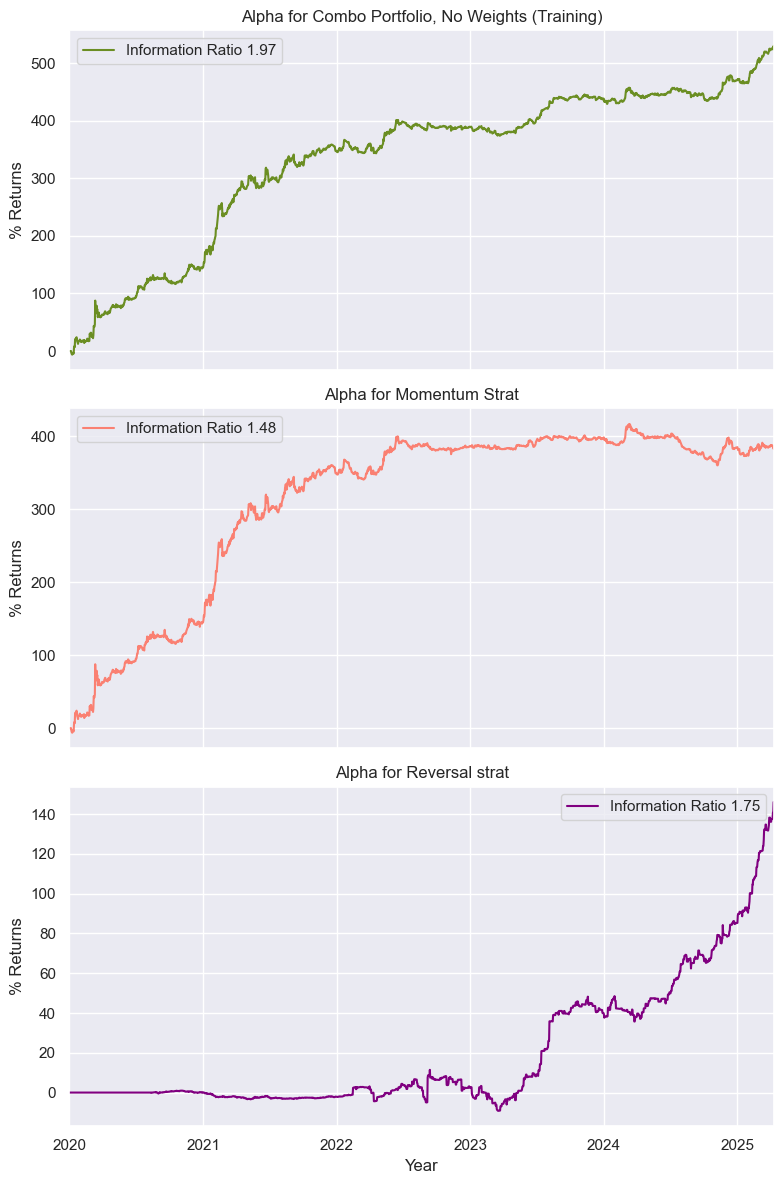

In [17]:
# Simple combination - equal weighting

rets = mom_rets.alpha + rev_rets.alpha #uncomment for equal weighting
ir = rets.mean()/rets.std()*np.sqrt(365)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)


(rets.cumsum()*100).plot(ax=axes[0], title = 'Alpha for Combo Portfolio, No Weights (Training)', xlabel = 'Year', 
                   ylabel = '% Returns', label = f"Information Ratio {ir:.2f}", color='olivedrab' ); axes[0].grid(True)

(mom_rets.alpha.cumsum()*100).plot(ax=axes[1], title='Alpha for Momentum Strat', xlabel = 'Year', ylabel = '% Returns', 
             label = f"Information Ratio {mom_rets.ir:.2f}", color='salmon' ); axes[1].grid(True)

(rev_rets.alpha.cumsum()*100).plot(ax=axes[2], title='Alpha for Reversal strat', xlabel = 'Year', ylabel = '% Returns', 
              label = f"Information Ratio {rev_rets.ir:.2f}", color='purple' ); axes[2].grid(True)

plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()


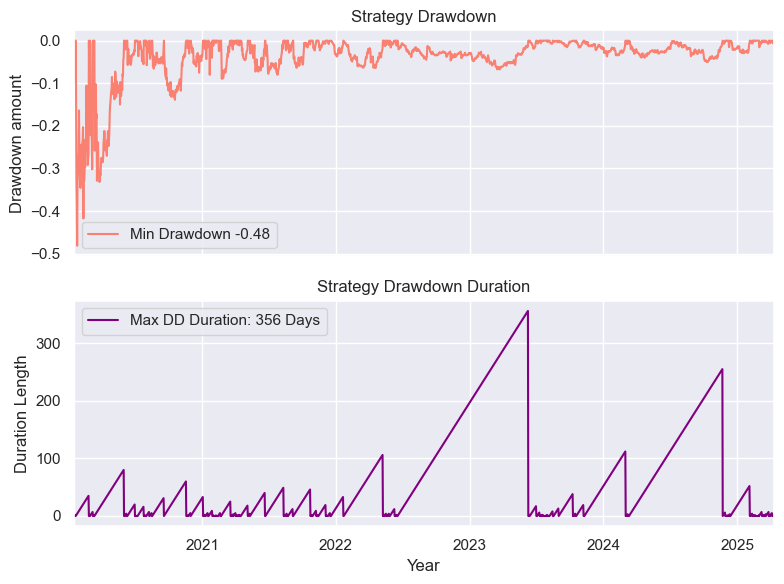

In [18]:
# Drawdown
# rets = (wgts[0]*mom_rets.gross_ret + wgts[1]*rev_rets.gross_ret)

rets_cumsum = rets.cumsum().iloc[15:] #brief noise, not indicitive of performance
rets_dd = drawdown(rets_cumsum)
min_dd = rets_dd.min()

# Duration
rets_dur = duration(rets_cumsum)
max_dur = rets_dur.max()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)


rets_dd.plot(ax=axes[0], title='Strategy Drawdown',xlabel = 'Year', ylabel = 'Drawdown amount', 
             label = f"Min Drawdown {min_dd:.2f}", color='salmon' ); axes[0].grid(True)
rets_dur.plot(ax=axes[1], title='Strategy Drawdown Duration',xlabel = 'Year', ylabel = 'Duration Length', 
              label = f"Max DD Duration: {max_dur:.0f} Days", color='purple' ); axes[1].grid(True)

plt.tight_layout()
axes[0].legend()
axes[1].legend()

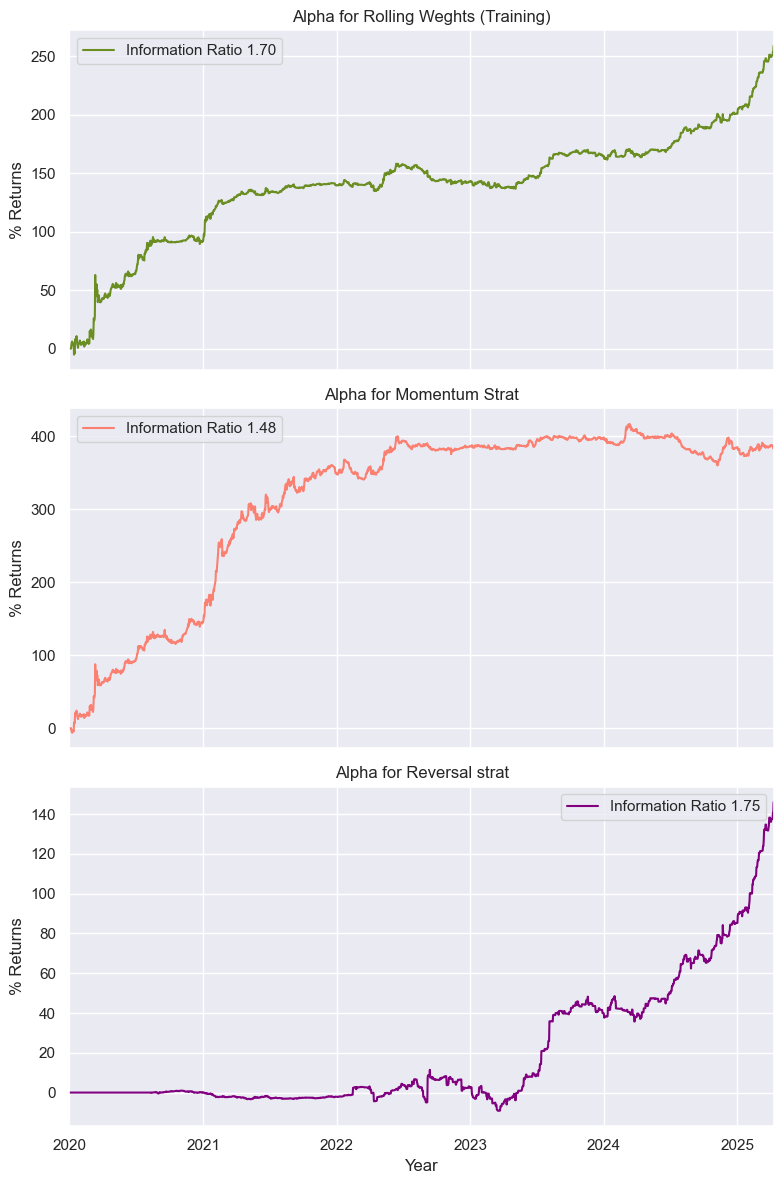

In [19]:
# Rolling weights based on mean and variance from previous year

combo_port = pd.concat([mom_rets.alpha, rev_rets.alpha], axis=1)
sigma = combo_port.rolling(365, min_periods=1).cov()
mu = combo_port.rolling(365, min_periods=1).mean()

wgts = []

for date, sig in sigma.groupby(level=0):
    
    mu_row = mu.loc[date]
    
    try:
        w = weights(sig, mu_row)       
    except np.linalg.LinAlgError:
        # on singular matrix (or inversion) failure, force NaNs
        w = pd.Series(
            data=np.nan,
            index=mu_row.index,
            name=date
        )

    wgts.append(w)

wgts = pd.DataFrame(wgts,index = combo_port.index) 
rets = (wgts.shift()*combo_port).sum(1)

ir = rets.mean()/rets.std()*np.sqrt(365)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)


(rets.cumsum()*100).plot(ax=axes[0], title = 'Alpha for Rolling Weghts (Training)', xlabel = 'Year', 
                         ylabel = '% Returns', label = f"Information Ratio {ir:.2f}", color='olivedrab' ); axes[0].grid(True)

(mom_rets.alpha.cumsum()*100).plot(ax=axes[1], title='Alpha for Momentum Strat', xlabel = 'Year', ylabel = '% Returns', 
                                   label = f"Information Ratio {mom_rets.ir:.2f}", color='salmon' ); axes[1].grid(True)

(rev_rets.alpha.cumsum()*100).plot(ax=axes[2], title='Alpha for Reversal strat', xlabel = 'Year', ylabel = '% Returns', 
                                   label = f"Information Ratio {rev_rets.ir:.2f}", color='purple' ); axes[2].grid(True)

plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()

## Apply to whole dataset

In [20]:
# Define trading universe

# Use high market cap coins for target security, but trade on all coins.
rev_univ = ret
high_rev = high
low_rev = low
close_rev = px
master_sec = 'BTCUSDT' #Choose BTCUSDT (Could be any big cap)

# Do momentum on high-market cap coins only
mom_univ = ret_big.fillna(0)
mom_cols = mom_univ.columns
high_mom = high[mom_cols].fillna(0)
low_mom = low[mom_cols].fillna(0)
close_mom = px[mom_cols].fillna(0)

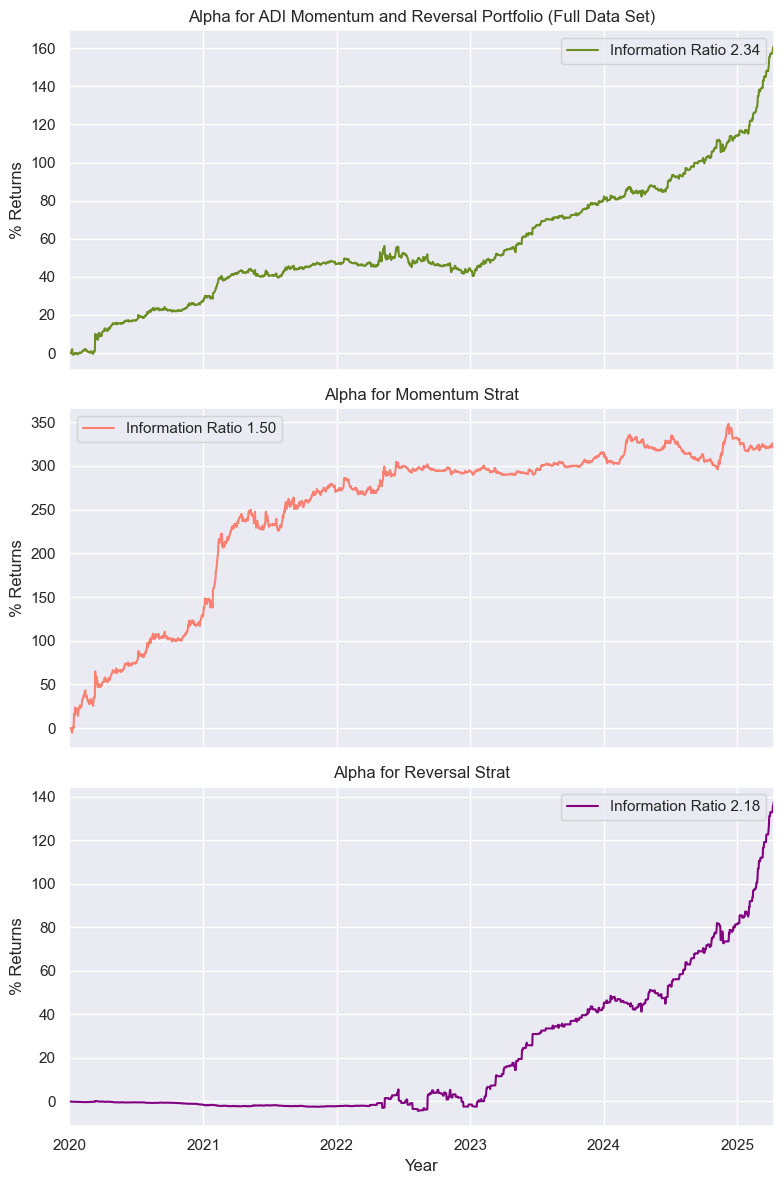

In [30]:
# Implement strategies

#### Reversal ####

# Perform rolling regression
roll_reg = rolling_regression(rev_univ, master_sec, window=30)

# Make trend signal
alpha = 0.35 #often 1/(day average), can be optimized
di = di_trend(high_rev,low_rev,close_rev,alpha)

# Momentum fits
asset = sma(mom_univ, 5).cumsum()
fit = ema(mom_univ, 0.1).cumsum()

# M/R sig threshold
thresh = 0.3
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

# Reversal components
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Reversal signal
rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec] = -1*rev_port.sum(1)

rev_rets = returns(rev_port, rev_univ)
rev_rets.norm()
rev_rets.gen_returns()

rev_beta = ret[master_sec].fillna(0)
rev_rets.purify(rev_beta)

# Momentum signal
mom_port = trend_crossing(asset, fit, di[0], threshold=thresh)

mom_rets = returns(mom_port, mom_univ)
mom_rets.norm()
mom_rets.gen_returns()

mom_beta = mom_univ.sum(1).fillna(0)
mom_rets.purify(beta)

# Combine strategies with rolling weights

# Make returns and covariance matrices
window = 700
combo_port = pd.concat([mom_rets.alpha, rev_rets.alpha], axis=1, keys = ['Momentum', 'Reversal'])
sigma = combo_port.rolling(window, min_periods=1).cov() # Choose same window as rolling regression
mu = combo_port.rolling(window, min_periods=1).mean()

wgts = []

# Do rolling weights 
for date, sig in sigma.groupby(level=0):
    
    mu_row = mu.loc[date]
    
    try:
        w = weights(sig, mu_row)       
    except np.linalg.LinAlgError:
        # on singular matrix (or inversion) failure, force NaNs
        w = pd.Series(
            data=np.nan,
            index=mu_row.index,
            name=date
        )

    wgts.append(w)

wgts = pd.DataFrame(wgts, index = combo_port.index, columns = combo_port.columns) 
rets = (wgts.shift()*combo_port).sum(1)

ir = rets.mean()/rets.std()*np.sqrt(365)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)


(rets.cumsum()*100).plot(ax=axes[0], title = 'Alpha for ADI Momentum and Reversal Portfolio (Full Data Set)', xlabel = 'Year', 
                   ylabel = '% Returns', label = f"Information Ratio {ir:.2f}", color='olivedrab' ); axes[0].grid(True)

(mom_rets.alpha.cumsum()*100).plot(ax=axes[1], title='Alpha for Momentum Strat', xlabel = 'Year', ylabel = '% Returns', 
             label = f"Information Ratio {mom_rets.ir:.2f}", color='salmon' ); axes[1].grid(True)

(rev_rets.alpha.cumsum()*100).plot(ax=axes[2], title='Alpha for Reversal Strat', xlabel = 'Year', ylabel = '% Returns', 
              label = f"Information Ratio {rev_rets.ir:.2f}", color='purple' ); axes[2].grid(True)

plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()
# plt.savefig('Combo and strats')

## Performance Evaluation

In [31]:
# Strategy correlation
corr =  rev_rets.alpha.corr(mom_rets.alpha)
print("Strategy correlation:", round(corr,4))

Strategy correlation: -0.0895


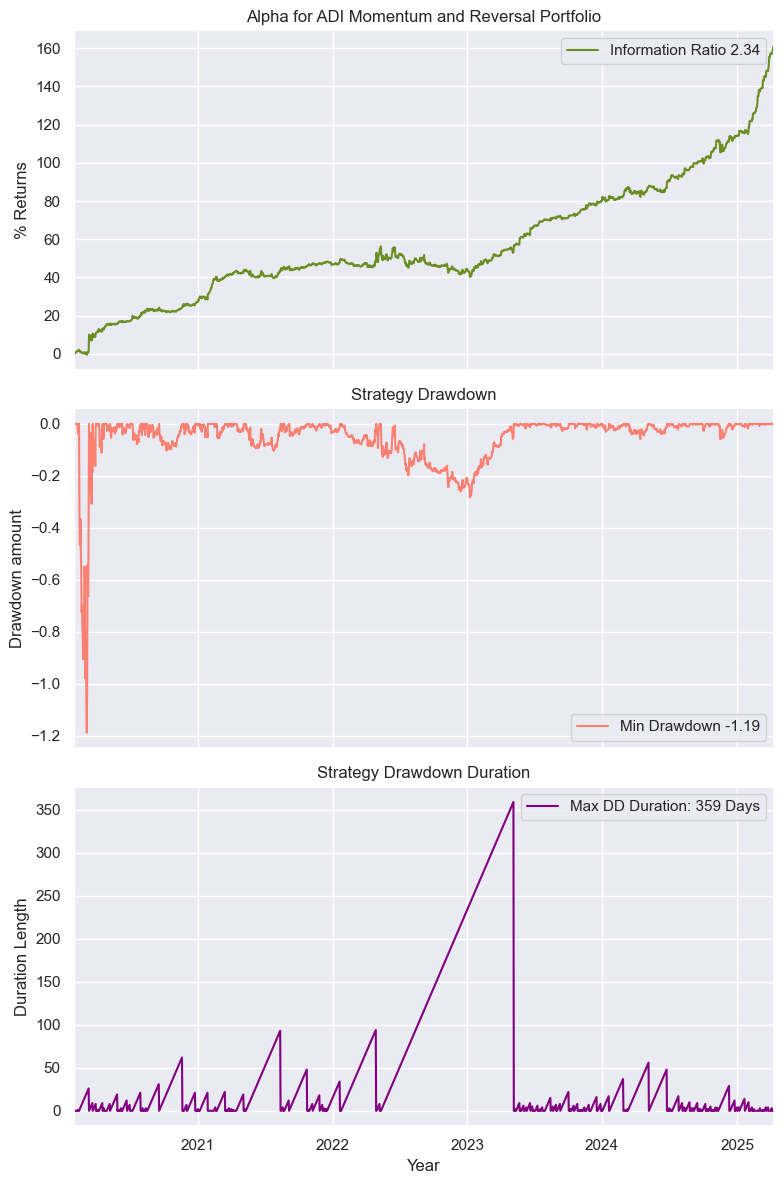

In [32]:
# Calcualte and plot
ir = rets.mean()/rets.std()*np.sqrt(365)
# Drawdown
rets_cumsum = rets.cumsum().iloc[30:]
rets_dd = drawdown(rets_cumsum) # Small drop causing calculation error
min_dd = rets_dd.min()

mom_dd = drawdown(mom_rets.alpha.cumsum())
min_mom_dd = mom_dd.min()

rev_dd = drawdown(rev_rets.alpha.cumsum())
min_rev_dd = rev_dd.min()

# Duration
rets_dur = duration(rets_cumsum)
max_dur = rets_dur.max()

mom_dur = duration(mom_rets.alpha.cumsum())
max_mom_dur = mom_dur.max()

rev_dur = duration(rev_rets.alpha.cumsum())
max_rev_dur = rev_dur.max()

# Plot
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)


(rets_cumsum*100).plot(ax=axes[0], title = 'Alpha for ADI Momentum and Reversal Portfolio', xlabel = 'Year', 
                   ylabel = '% Returns', label = f"Information Ratio {ir:.2f}", color='olivedrab' ); axes[0].grid(True)

rets_dd.plot(ax=axes[1], title='Strategy Drawdown',xlabel = 'Year', ylabel = 'Drawdown amount', 
             label = f"Min Drawdown {min_dd:.2f}", color='salmon' ); axes[1].grid(True)

rets_dur.plot(ax=axes[2], title='Strategy Drawdown Duration',xlabel = 'Year', ylabel = 'Duration Length', 
              label = f"Max DD Duration: {max_dur:.0f} Days", color='purple' ); axes[2].grid(True)

plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()
# plt.savefig('strat dd and dur')

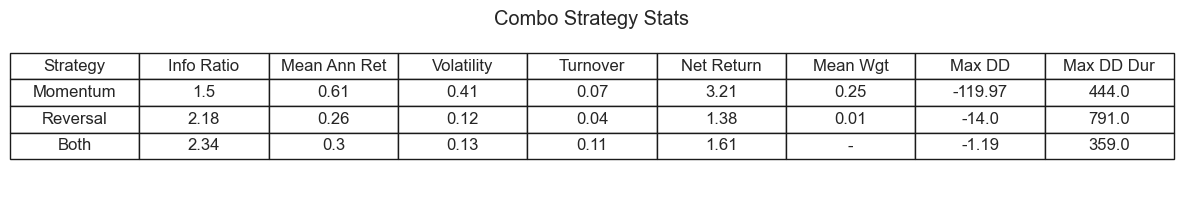

In [33]:
# Prepare table
data = {
    'Strategy': ['Momentum', 'Reversal', 'Both'],
    'Info Ratio': [round(mom_rets.ir,2), round(rev_rets.ir,2), round(ir,2)],
    'Mean Ann Ret':[round(mom_rets.alpha.mean()*365,2), round(rev_rets.alpha.mean()*365,2), round(rets.mean()*365,2)], 
    'Volatility': [round(mom_rets.alpha.std()*np.sqrt(365),2), round(rev_rets.alpha.std()*np.sqrt(365),2), 
                   round(rets.std()*np.sqrt(365),2)],
    'Turnover': [round(mom_rets.to.mean(), 2), round(rev_rets.to.mean(), 2), 
                 round((rev_rets.to.mean() + mom_rets.to.mean()), 2)],
    'Net Return': [round(mom_rets.alpha.cumsum().iloc[-1], 2), round(rev_rets.alpha.cumsum().iloc[-1], 2), 
                  round(rets_cumsum.iloc[-1], 2)],
    'Mean Wgt': [round(wgts['Momentum'].mean(),2), round(wgts['Reversal'].mean(),2), '-',],
    'Max DD':  [round(min_mom_dd,2), round(min_rev_dd,2), round(min_dd,2)],
    'Max DD Dur': [max_mom_dur, max_rev_dur, max_dur]
}

table = pd.DataFrame(data)

#  Create a figure and hide axes
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')  # turn off the x/y axis

# Add the table
tbl = ax.table(
    cellText=table.values,        
    colLabels=table.columns,      
    cellLoc='center',          
    loc='center'               
)

# Scaling
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 1.5)  

# Plot
plt.tight_layout()
fig.suptitle("Combo Strategy Stats")
plt.show()
# plt.savefig('combo stats')